## 範例重點
* 學習如何在 keras 中加入自定義的 callbacks
* 知道 callback function 可以動作的時機

In [1]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline


# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

2021-11-23 08:17:02.906337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 08:17:02.906397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [14]:
"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def __init__(self, val_data=(x_test, y_test)):
        self.validation_data = val_data
    
    def on_train_begin(self, epoch, logs = {}):
        self.params['metrics'] = []
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
        
        '''
        for i in record_items:
            try:
                if i not in self.params['metrics']:
                    self.params['metrics'].append(i)
            except:
                self.params['metrics']=i
        '''
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [16]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.gradient_descent_v2.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# 在訓練後，將 f1sc 紀錄調出
valid_f1sc = model.history.history['val_f1sc']

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512 

/home/wanzi/ml/cupoyMarathon/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-23 08:25:36.479156: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
49/49 [==============================] - 4s 65ms/step - loss: 2.2188 - accuracy: 0.2687 - val_loss: 2.1032 - val_accuracy: 0.2269
Epoch 2/50
49/49 [==============================] - 3s 53ms/step - loss: 1.7474 - accuracy: 0.3928 - val_loss: 1.9702 - val_accuracy: 0.2916
Epoch 3/50
49/49 [==============================] - 3s 60ms/step - loss: 1.6207 - accuracy: 0.4364 - val_loss: 1.8449 - val_accuracy: 0.3581
Epoch 4/50
49/49 [==============================] - 4s 73ms/step - loss: 1.5482 - accuracy: 0.4614 - val_loss: 1.7232 - val_accuracy: 0.4009
Epoch 5/50
49/49 [==============================] - 2s 48ms/step - loss: 1.4909 - accuracy: 0.4812 - val_loss: 1.6395 - val_accuracy: 0.4321
Epoch 6/50
49/49 [==============================] - 4s 74ms/step - loss: 1.4448 - accuracy: 0.4937 - val_loss: 1.5879 - val_accuracy: 0.4494
Epoch 7/50
49/49 [==============================] - 2s 49ms/step - loss: 1.4060 - accuracy: 0.5082 - val_loss: 1.5606 - val_accuracy: 0.4525
Epoch 8/50
49

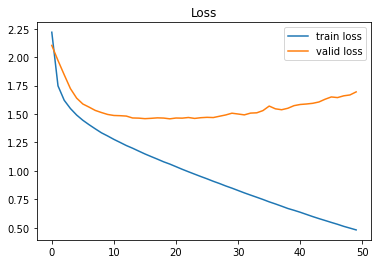

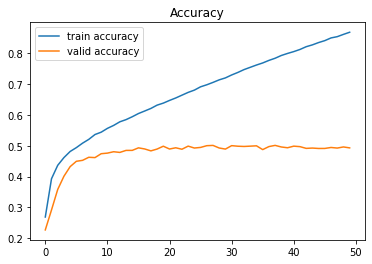

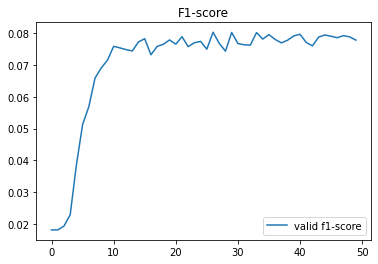

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()


## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative